In [1]:
import sys, os
import numpy as np
sys.path.append('../src/')
import torch
from MolGraphNetwork import MolGraphNetwork
from utils import find_repo_root
from scf_guess_tools import Backend
from scf_guess_datasets import Qm9Isomeres

project_root_dir = find_repo_root()
print("Project root directory:", project_root_dir)
BASIS_PATH = "../../../scripts/6-31g_2df_p_custom_nwchem.gbs"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Project root directory: /home/ewachmann/REPOS/Masterarbeit
Using device: cuda


In [2]:
dataset = Qm9Isomeres(
    "/home/dmilacher/datasets/data", 
    size = 500, # number of molecules to load
    split_ratio=0.8, # using 80% training / 10 % val / 10% test split
)

In [3]:
MGNN = MolGraphNetwork(dataset=dataset,
                       basis=BASIS_PATH,
                       backend=Backend.PY,
                       batch_size=16,
                       hidden_dim=256,
                       message_passing_steps=3,
                       edge_threshold_val=5,
                       message_net_layers=3,
                       message_net_dropout=0.1,
                       target="density",
                       data_aug_factor=3,
                       verbose_level=2)
MGNN.load_data()

Setting verbose level to: 2
Loading 500 files from qm9_isomeres...
Loading 400 files for train set from /home/ewachmann/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres/xyz...
Loading 50 files for val set from /home/ewachmann/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres/xyz...
Loading 50 files for test set from /home/ewachmann/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres/xyz...


Creating training graphs: 400it [00:03, 114.09it/s]


Augmenting training set using factor 3 -> 800 additional training samples.


Augmenting data: 100%|██████████| 800/800 [04:03<00:00,  3.28it/s]
Creating validation graphs: 50it [00:00, 108.76it/s]
Creating test graphs: 50it [00:00, 123.48it/s]


Total samples: 2100, Train: 400 (with 800 / 400 augmented samples), Val: 50, Test: 50
Found 3 center keys (['C', 'H', 'O']) and 6 edge keys (['C_C', 'C_H', 'C_O', 'H_H', 'H_O', 'O_O']) in the training set. -> Totaling 9 unique encoder/decoder.
Normalization factors computed and applied.
Center stats: {'C': (0.08893045239638739, 0.27210393758102025), 'H': (0.3772194703420003, 0.468965563609298), 'O': (0.08820201116919178, 0.2707920626400333)}, Edge stats: {'C_C': (0.0009685880859746539, 0.059981176278629644), 'C_H': (0.0033186904353978133, 0.06443038497266414), 'C_O': (0.00040553822239177, 0.04369668287719623), 'H_H': (0.005929835588323659, 0.03711932313657346), 'H_O': (0.0016907755433787507, 0.039003715259383565), 'O_O': (-4.3751104506813056e-05, 0.007314701356196092)}
First train batch: 304 atoms, 5104 edges, 304 center blocks.
Found center block size 351 for atom type C.
Found center block size 351 for atom type O.
Found center block size 15 for atom type H.
Found edge block size 676

In [ ]:
RETRAIN = False  
model_name = "MGNN_6-31G_data_aug"
if not RETRAIN and os.path.exists(f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}.pth"):
    MGNN.load_model(f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}.pth")
else:
    MGNN.train_model(num_epochs=100, lr=1e-3, weight_decay=1e-4, grace_epochs=5, model_save_path=f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}.pth")
    MGNN.save_model(f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}.pth")

Epoch 1 [Train]:  12%|█▏        | 9/75 [00:09<01:09,  1.05s/it]


Training interrupted by user. Benchmark model...


Epoch 1 [Test]: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]

Test  Loss: 89.973196
Model saved to /home/ewachmann/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_data_aug.pth


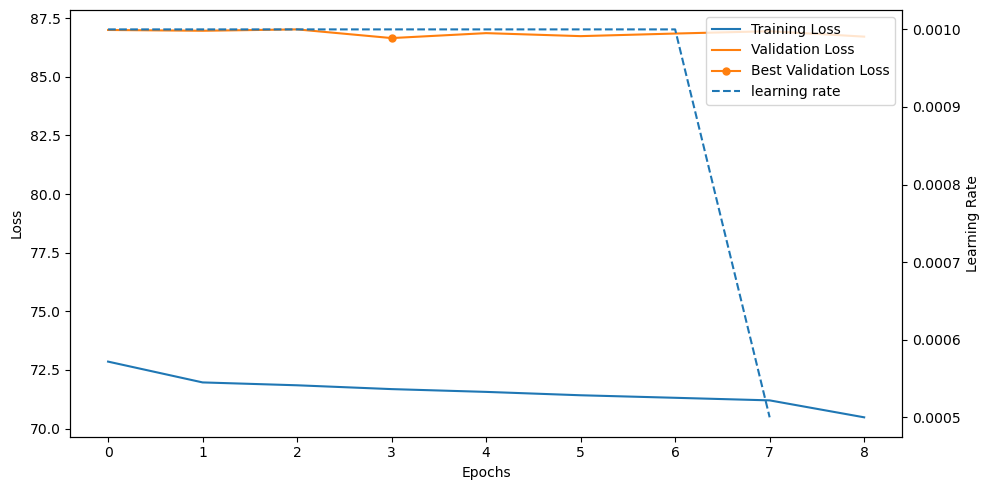

In [22]:
import pickle
from matplotlib import pyplot as plt
with open(f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}.history", "rb") as f: 
    hist = pickle.load(f)
# hist["train_loss"]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hist["train_loss"], label="Training Loss", color="tab:blue")
ax.plot(hist["val_loss"], label="Validation Loss", color="tab:orange")
ax.plot(np.array(hist["val_loss"]).argmin(), hist["val_loss"][np.array(hist["val_loss"]).argmin()],
         marker="o", markersize=5, color="tab:orange", label="Best Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax2 = ax.twinx()
ax2.plot(hist["lr"], linestyle="--", label="learning rate")
ax2.set_ylabel("Learning Rate")
ax2.tick_params(axis='y')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper right")
plt.tight_layout()
plt.show()

In [7]:
test_graphs = MGNN.get_graphs("test")

In [8]:
# aux code for testing
sys.path.append('../../')
from utils import plot_mat_comp

randsample_id = np.random.randint(0, len(test_graphs))
print(f"Testing on random sample with id {randsample_id}")
test_graph = test_graphs[randsample_id]

Testing on random sample with id 46


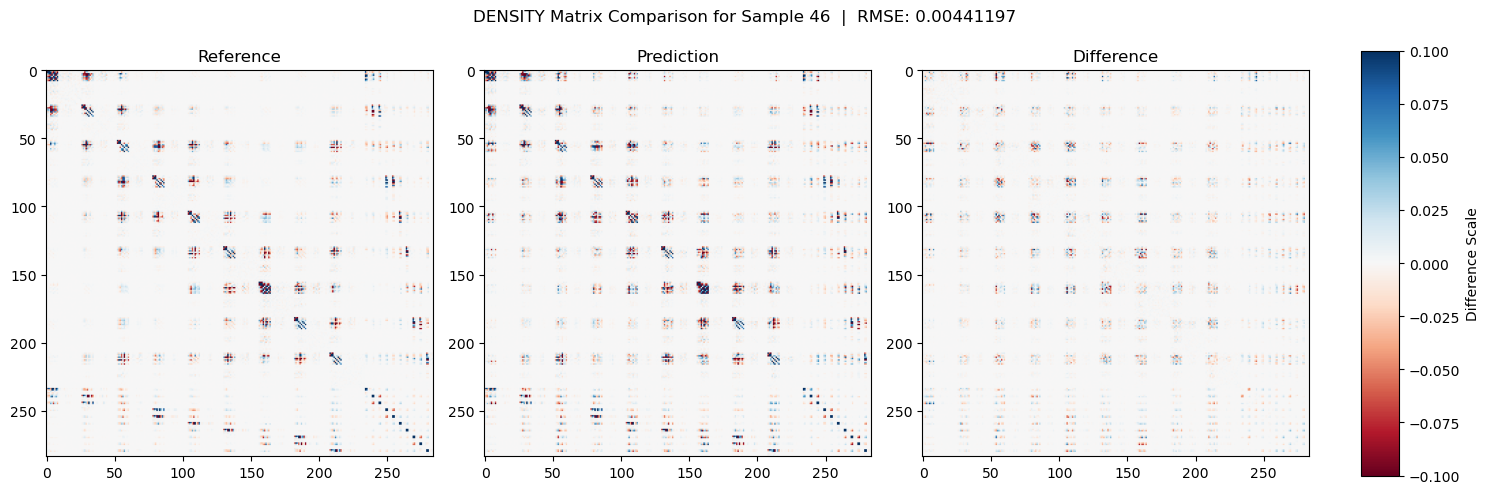

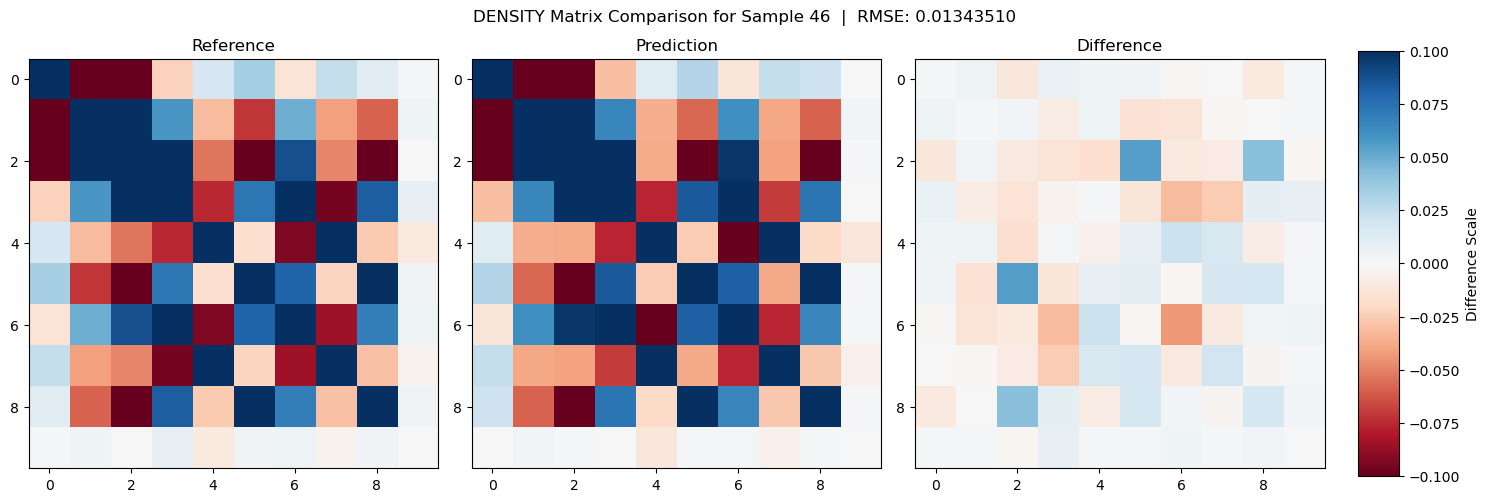

In [9]:
density_pred, density_truth = MGNN.predict([test_graph], include_target=True, transform_to_density=True)[0]
plot_mat_comp(density_pred, density_truth, 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)
plot_mat_comp(density_pred[:10,:10], density_truth[:10,:10], 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)

ok this already look pretty good for very few training runs!

In [10]:
from scf_guess_tools import load, calculate, guess
from scipy.linalg import eigh
from pyscf import gto, scf

In [11]:
# default calc using minao guess!
rand_file = MGNN.get_files("test")[randsample_id]
print(rand_file)
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_minao = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess="minao")

/home/ewachmann/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres/xyz/dsC7O2H10nsd_5126.xyz
Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.115936271158


In [12]:
density_pred = density_pred.astype(np.float64)

In [13]:
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_own = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess=density_pred)

Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.115936271322


In [14]:
# ground truth guess
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_gt = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess=density_truth)

Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.11593627133


In [15]:
cycles_minao, cycles_own, cycles_gt = wf_minao.native.cycles, wf_own.native.cycles, wf_gt.native.cycles
print(f"Cycles with minao guess: {cycles_minao}, cycles with own guess: {cycles_own}, cycles with ground truth guess: {cycles_gt}")

Cycles with minao guess: 10, cycles with own guess: 11, cycles with ground truth guess: 5


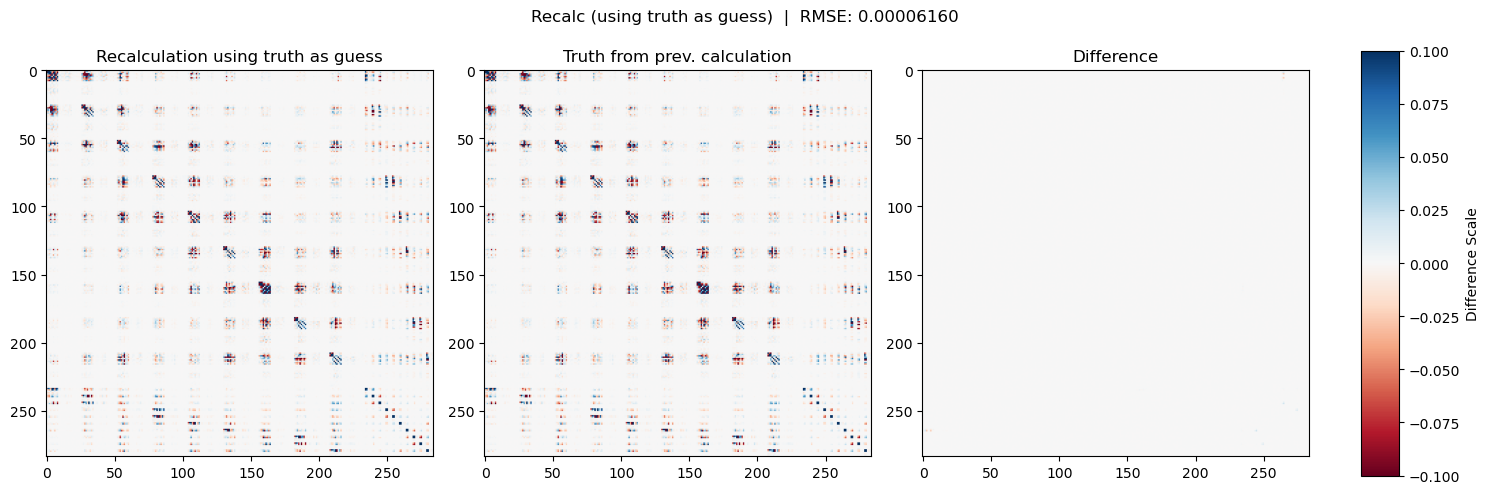

In [16]:
plot_mat_comp(wf_minao._D, density_truth, title="Recalc (using truth as guess)", ref_title="Recalculation using truth as guess", pred_title="Truth from prev. calculation", vmax=0.1)

# Iteration Benchmark

In [17]:
%pip install uncertainties

Note: you may need to restart the kernel to use updated packages.


In [18]:
from time import time
from uncertainties import ufloat
import scf_guess_datasets

In [19]:
start_time = time()
density_preds = MGNN.predict(test_graphs, include_target=False, transform_to_density=True)
pred_time = time() - start_time # stat benchmarking later
print(f"Prediction time for {len(test_graphs)} samples: {pred_time:.2f} seconds - {pred_time/len(test_graphs):.4f} seconds per sample")

files = MGNN.get_files("test")
print(f"Number of test files: {len(files)}")

cycles =  []
print("Testing for iteration count")

Prediction time for 50 samples: 4.12 seconds - 0.0824 seconds per sample
Number of test files: 50
Testing for iteration count


In [20]:
# own 
test_keys = dataset.val_keys[len(dataset.val_keys)//2:]  # only use half of the validation set -> which is the test set used by the model!
for i, density_pred in enumerate(density_preds):
    solver = dataset.solver(test_keys[i])
    overlap, hcore, density, fock, status = scf_guess_datasets.solve(solver, density_pred.astype(np.float64))
    cycles.append(status.iterations)
    print(f"Sample {i}: Cycles with own guess: {status.iterations}")


KeyboardInterrupt: 

In [ ]:
mean_own = np.mean(cycles)
std_own = np.std(cycles)
iter_own = ufloat(mean_own, std_own)
print(f"Average iterations with own guess: {iter_own:.2f}")
with open(f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}_cycles.pkl", "wb") as f:
    pickle.dump(cycles, f)

Average iterations with own guess: 10.96+/-0.44


In [ ]:
with open(f"{project_root_dir}/3_studies/Block_guessing/models/MGNN_6-31G_no_data_aug_cycles.pkl", "rb") as f:
    cycles_minao = pickle.load(f)
mean_minao = np.mean(cycles_minao)
std_minao = np.std(cycles_minao)
iter_minao = ufloat(mean_minao, std_minao)
print(f"Average iterations with minao guess: {iter_minao:.2f} no data augmentation")

Average iterations with minao guess: 10.96+/-0.44 no data augmentation
